6/23/2018

# P&S applied to King County Yelp Data.
This notebook plotss feature importaance from fitted RF model on random 80-20 train/test split and also plots one tree from fitted model. These figures correspond with the appendix figures.

In [1]:
from __future__ import division
from matplotlib.backends.backend_pdf import PdfPages
import os
from sklearn.model_selection import KFold
import re, ast
import platform
import sklearn.cross_validation
import matplotlib.pyplot as plt

execfile('../../functions/python_libraries.py')
execfile('../../functions/simulation_functions.py')

/Users/kristen/anaconda/lib/python2.7/site-packages/sklearn/cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
## Kang et al. data + Dan's additional data processing (Asian/non-Asian, year, etc.)
#dta = pd.read_csv('../../../data/KangData_with_additional_features.csv')
dta = pd.read_csv('../../../../../../../kristen_sandbox/KangData_with_additional_features.csv')

## note there's observation with -1 inspection score. We set to 0.
dta.inspection_penalty_score[dta.inspection_penalty_score==-1]=0
dta.inspection_average_prev_penalty_scores[dta.inspection_average_prev_penalty_scores==-1]=0
dta.inspection_prev_penalty_score[dta.inspection_prev_penalty_score==-1]=0

/Users/kristen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kristen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/Users/kristen/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [3]:
features = ['inspection_average_prev_penalty_scores', 'inspection_prev_penalty_score', # SAP
            'inspection_penalty_score', # y
            'asian', # SUP
            'poison', 'vomit','diarrhea', 'sick2', # CP
            'review_count', 'average_review_rating', 'non_positive_review_count'] # CP


ny_df_subset = dta[features]
ny_df_subset.columns

Index([u'inspection_average_prev_penalty_scores',
       u'inspection_prev_penalty_score', u'inspection_penalty_score', u'asian',
       u'poison', u'vomit', u'diarrhea', u'sick2', u'review_count',
       u'average_review_rating', u'non_positive_review_count'],
      dtype='object')

In [4]:
ny_df_subset.columns = ['inspection_average_prev_penalty_scores_SAP', 'inspection_prev_penalty_score_SAP',
                        'y',
                        'asian_SUP',
                        'poison_CP', 'vomit_CP','diarrhea_CP', 'sick_CP',
                        'review_count_SAP', 'average_review_rating_SAP', 'non_positive_review_count_SAP']

In [5]:
SAP_cols = [s for s in np.array(ny_df_subset.columns) if "SAP" in s]
print SAP_cols
CP_cols = [s for s in np.array(ny_df_subset.columns) if "CP" in s]
print CP_cols

['inspection_average_prev_penalty_scores_SAP', 'inspection_prev_penalty_score_SAP', 'review_count_SAP', 'average_review_rating_SAP', 'non_positive_review_count_SAP']
['poison_CP', 'vomit_CP', 'diarrhea_CP', 'sick_CP']


# One Train/Test Split for RF Model

In [6]:
clf = sklearn.ensemble.RandomForestRegressor()
max_depth = [3, 5, 10]
max_depth.append(None) 
min_samples_leaf = [5, 10, 20, 50, 100]
min_samples_split = [2, 3, 4, 5, 10] 
n_estimators = [50, 100, 150] #[10, 50, 100, 150, 200]
max_features = ['auto', 0.25, 0.5, 0.75] 
random_grid = {'max_depth': max_depth,
            'min_samples_leaf': min_samples_leaf,
              'max_features': max_features,
              'n_estimators': n_estimators,
              'min_samples_split': min_samples_split}

model = GridSearchCV(estimator = clf,
                param_grid = random_grid,
                cv = 3, verbose=0,
                n_jobs = -1)

In [7]:
k_fold = sklearn.cross_validation.ShuffleSplit(len(ny_df_subset.y), n_iter=1,
                                                         test_size=0.2,
                                                         random_state=0)

for k, (train, test) in enumerate(k_fold):
    print k
    df_subset_train = ny_df_subset.iloc[train,:]
    df_subset_test = ny_df_subset.iloc[test,:]


0


# Justify Hyperparameter Grid Range

In [31]:
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_ensemble_oob.html
from collections import OrderedDict
RANDOM_STATE = 123

ensemble_clfs = [
    ("RF, max_depth=3",
        sklearn.ensemble.RandomForestRegressor(warm_start=True, oob_score=True,max_depth = 3,
                               max_features='auto',
                               random_state=RANDOM_STATE)),
    ("RF, max_depth=5",
        sklearn.ensemble.RandomForestRegressor(warm_start=True, max_features='auto',max_depth = 5,
                               oob_score=True,
                               random_state=RANDOM_STATE)),
    ("RF, max_depth=10",
        sklearn.ensemble.RandomForestRegressor(warm_start=True, max_features='auto',max_depth = 10,
                               oob_score=True,
                               random_state=RANDOM_STATE))
]

error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)



# Range of `n_estimators` values to explore.
min_estimators = 5
max_estimators = 200

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 5):
        #print i
        clf.set_params(n_estimators=i)
        clf.fit(df_subset_train[sum([SAP_cols, CP_cols, ['asian_SUP']], [])], 
                    df_subset_train.y)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))



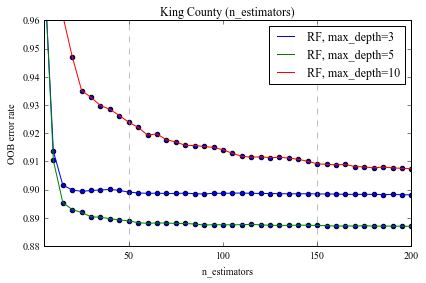

In [32]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
    plt.scatter(xs, ys)#, label=label)

plt.axvline(50, color = 'gray', alpha = 0.5, ls = '--')
plt.axvline(150, color = 'gray', alpha = 0.5, ls = '--')


plt.xlim(min_estimators, max_estimators)
plt.ylim(0.88, 0.96)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.title('King County (n_estimators)')
plt.legend(loc="upper right")

plt.tight_layout()
pp = PdfPages("./figs/KC_n_estimators_all_other_parameters_default.pdf")
pp.savefig()
pp.close()

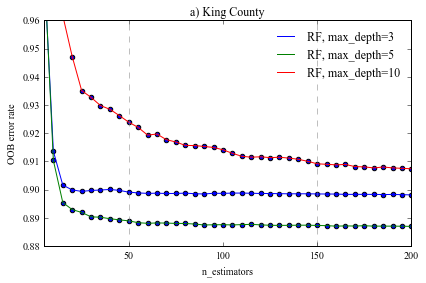

In [33]:
# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)
    plt.scatter(xs, ys)#, label=label)

plt.axvline(50, color = 'gray', alpha = 0.5, ls = '--')
plt.axvline(150, color = 'gray', alpha = 0.5, ls = '--')


plt.xlim(min_estimators, max_estimators)
plt.ylim(0.88, 0.96)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.title('a) King County')
plt.legend(loc="upper right", frameon=False)

plt.tight_layout()
#pp = PdfPages("./figs/KC_n_estimators_all_other_parameters_default.pdf")
#pp.savefig()
#pp.close()
plt.savefig('./figs/KC_n_estimators_all_other_parameters_default.eps', format='eps', dpi=1000)


# Feature Importance

In [11]:
print SAP_cols
print CP_cols
print ['asian_SUP']

['inspection_average_prev_penalty_scores_SAP', 'inspection_prev_penalty_score_SAP', 'review_count_SAP', 'average_review_rating_SAP', 'non_positive_review_count_SAP']
['poison_CP', 'vomit_CP', 'diarrhea_CP', 'sick_CP']
['asian_SUP']


In [12]:
# fit model
model.fit(df_subset_train[sum([SAP_cols, CP_cols, ['asian_SUP']], [])], 
                    df_subset_train.y)

GridSearchCV(cv=3, error_score='raise',
       estimator=RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
           oob_score=False, random_state=None, verbose=0, warm_start=False),
       fit_params=None, iid=True, n_jobs=-1,
       param_grid={'max_features': ['auto', 0.25, 0.5, 0.75], 'n_estimators': [50, 100, 150], 'min_samples_split': [2, 3, 4, 5, 10], 'max_depth': [3, 5, 10, None], 'min_samples_leaf': [5, 10, 20, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

In [13]:
imp = model.best_estimator_.feature_importances_
names = sum([SAP_cols, 
             CP_cols, ['asian_SUP']], [])

In [14]:
print names

['inspection_average_prev_penalty_scores_SAP', 'inspection_prev_penalty_score_SAP', 'review_count_SAP', 'average_review_rating_SAP', 'non_positive_review_count_SAP', 'poison_CP', 'vomit_CP', 'diarrhea_CP', 'sick_CP', 'asian_SUP']


In [15]:
print SAP_cols
print CP_cols
names = ['Avg. prior score',
                    'Prior score','# of reviews', '5-star rating', '# non-positive reviews',#'non-positive review count',
                         '\"poison\"', '\"vomit\"',
        '\"diarrhea\"', '\"sick\"', 
    
        'Is Asian']

['inspection_average_prev_penalty_scores_SAP', 'inspection_prev_penalty_score_SAP', 'review_count_SAP', 'average_review_rating_SAP', 'non_positive_review_count_SAP']
['poison_CP', 'vomit_CP', 'diarrhea_CP', 'sick_CP']


In [23]:
print len(names)
print len(imp)

10
10


In [16]:
from matplotlib.backends.backend_pdf import PdfPages


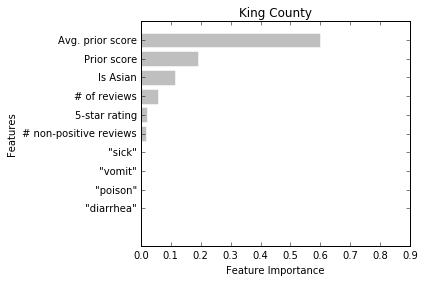

In [17]:
imp, names = zip(*sorted(zip(imp,names)))

%matplotlib inline
plt.barh(range(len(names)), imp, align = 'center', alpha = 0.5, edgecolor='white', color = 'gray')
plt.yticks(range(len(names)), names)
plt.xlabel('Feature Importance')
plt.title('King County')
plt.ylabel('Features')
plt.xlim(0,0.9)
plt.tight_layout()
pp = PdfPages('./figs/KingCounty_feature_importance.pdf')
pp.savefig()
pp.close()

In [18]:
plt.rcParams["font.family"] = "Times New Roman"


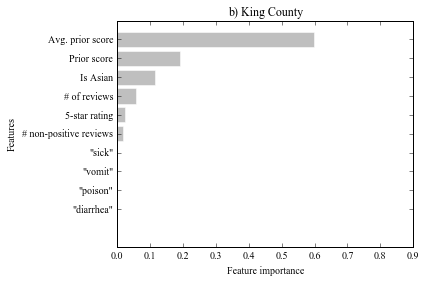

In [19]:
imp, names = zip(*sorted(zip(imp,names)))

%matplotlib inline
plt.barh(range(len(names)), imp, align = 'center', alpha = 0.5, edgecolor='white', color = 'gray')
plt.yticks(range(len(names)), names)
plt.xlabel('Feature importance')
plt.title('b) King County')
plt.ylabel('Features')
plt.xlim(0,0.9)
plt.tight_layout()
plt.savefig('./figs/KingCounty_feature_importance.eps', format='eps', dpi=1000)


In [20]:
print imp
print names

(0.0, 0.0, 0.0, 6.633180006034862e-05, 0.016933311753418813, 0.02220411635513888, 0.05572786104081077, 0.11421859173355245, 0.1921964255227084, 0.5986533617943103)
('"diarrhea"', '"poison"', '"vomit"', '"sick"', '# non-positive reviews', '5-star rating', '# of reviews', 'Is Asian', 'Prior score', 'Avg. prior score')


# Visualize Decision Tree from RF Model

In [25]:
len(model.best_estimator_.estimators_)

50

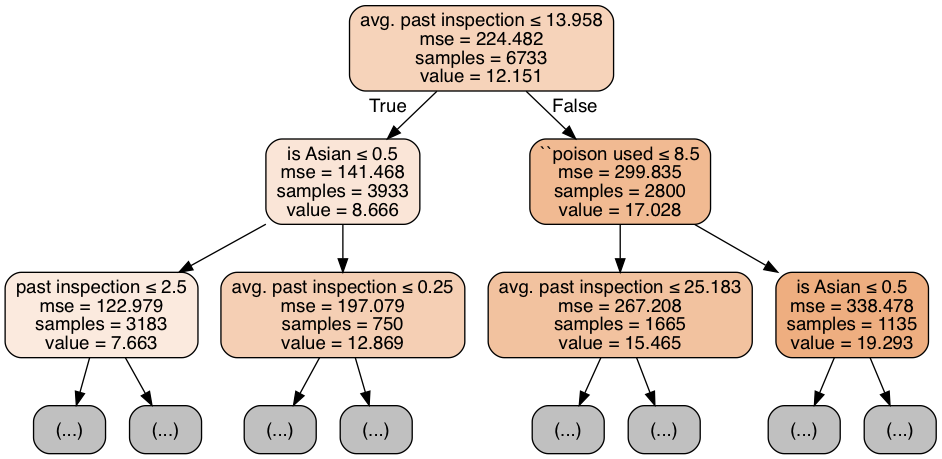

In [30]:
tree_id = 45 #88

%matplotlib inline

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model.best_estimator_.estimators_[tree_id], out_file=dot_data,  
                feature_names = ['avg. past inspection', 'past inspection',
        '``poison'' used', '``vomit'' used',
        '``diarrhea'' used', '``sick'' used', 'review count', 'avg. review rating',
                                 'non-positive review count', 'is Asian'],
                max_depth = 2,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("./figs/KC_DT_full_depth2.pdf")
#graph.write_ps("./figs/KC_DT_full_depth2.eps")
Image(graph.create_png())


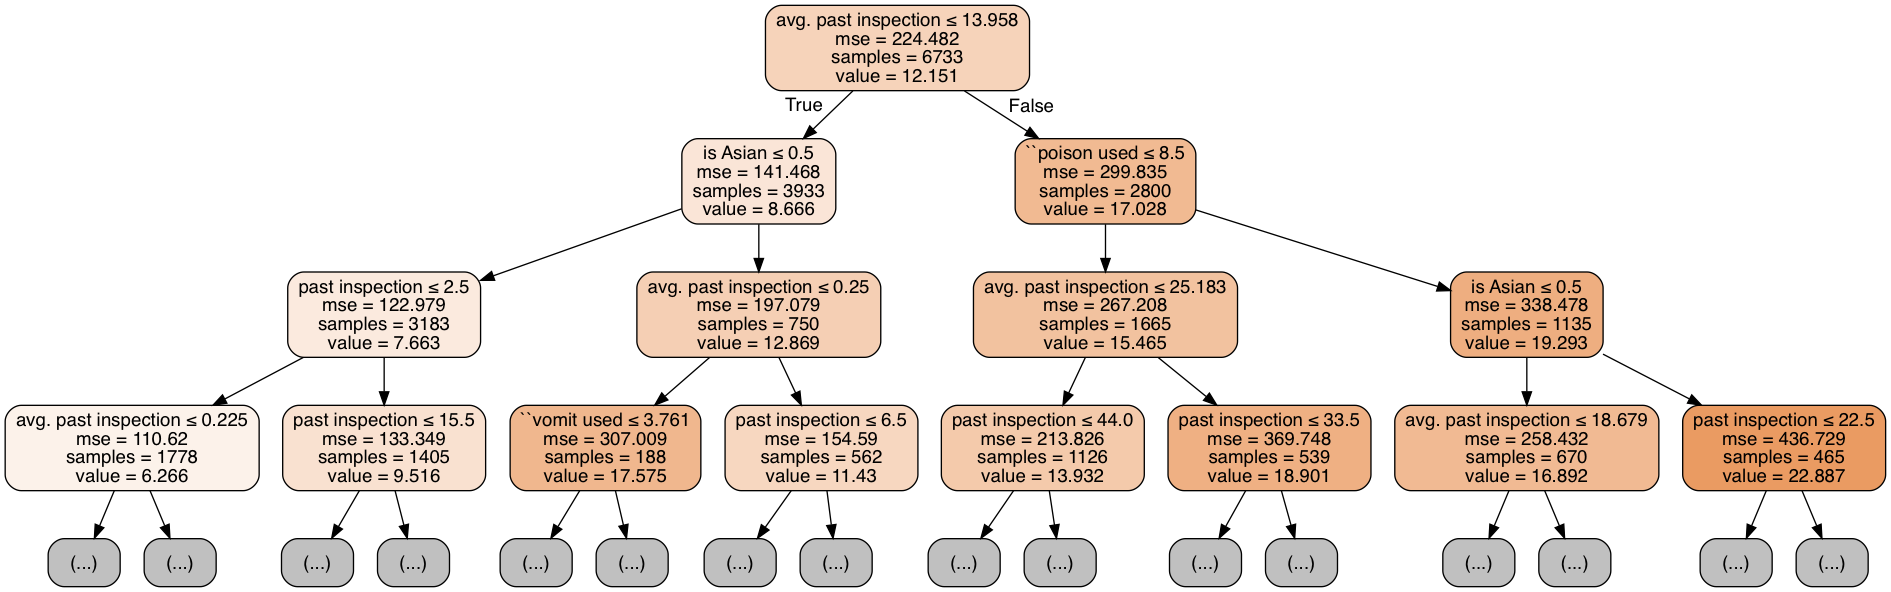

In [27]:
%matplotlib inline

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model.best_estimator_.estimators_[tree_id], out_file=dot_data,  
                feature_names =['avg. past inspection', 'past inspection',
        '``poison'' used', '``vomit'' used',
        '``diarrhea'' used', '``sick'' used', 'review count', 'avg. review rating',
                                 'non-positive review count', 'is Asian'],
                max_depth = 3,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("./figs/KC_DT_full_depth_3.pdf")


Image(graph.create_png())




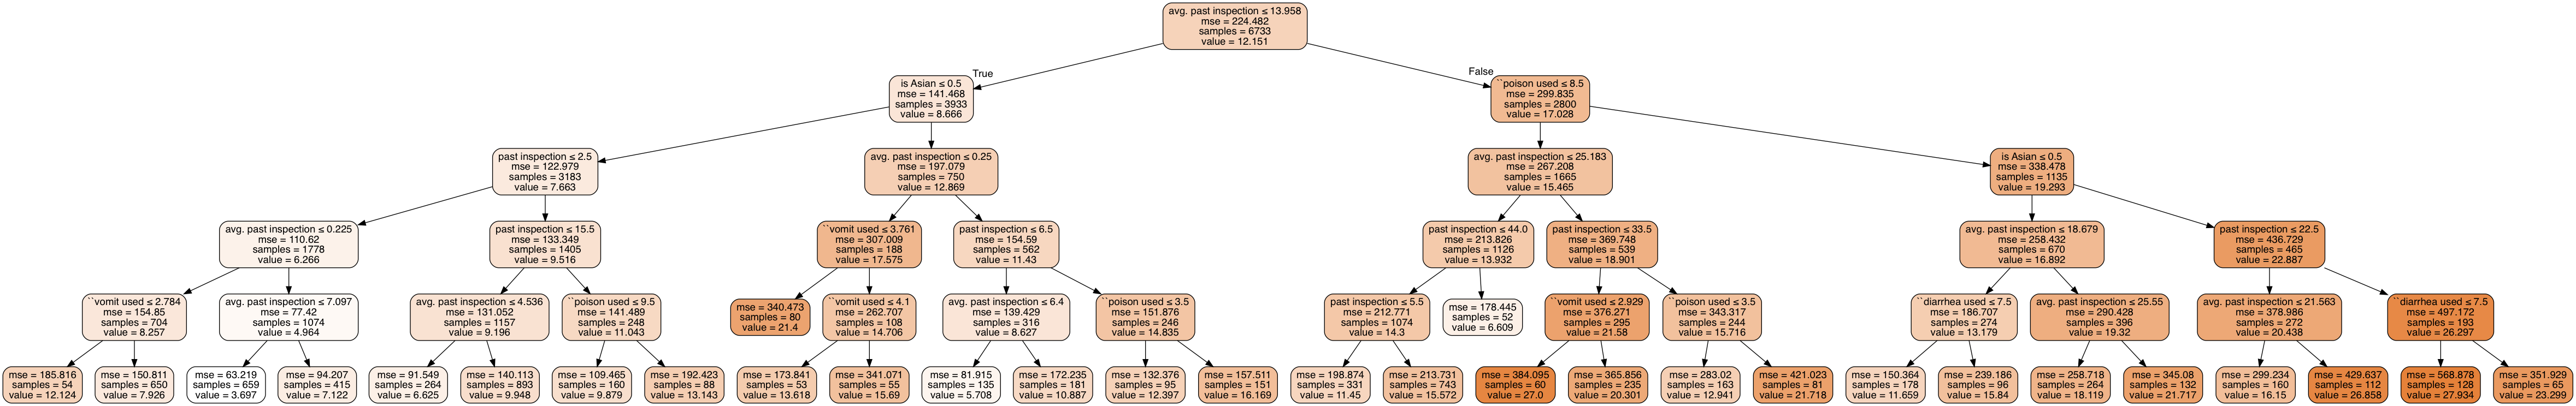

In [28]:
%matplotlib inline

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(model.best_estimator_.estimators_[tree_id], out_file=dot_data,  
                feature_names = ['avg. past inspection', 'past inspection',
        '``poison'' used', '``vomit'' used',
        '``diarrhea'' used', '``sick'' used', 'review count', 'avg. review rating',
                                 'non-positive review count', 'is Asian'],
                #max_depth = 4,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
graph.write_pdf("./figs/KC_DT_full.pdf")


Image(graph.create_png())


